In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
@import url('https://fonts.googleapis.com/css2?family=Source+Code+Pro&display=swap');
</style>
""")

# HuBMAP - Simple getting started with Image, Mask and Bounding Box
<h4 style="font-family: 'Source Code Pro', monospace">Version 9: Also contains how to generate the dataset on your own</h4>
<a href="https://www.kaggle.com/ckanth090/hubmap-5185x256x256-image-and-masks">Link to my dataset - contains 5185x256x256 images</a><br><br>


### Contents
1. [Glomerular Identification meaning](#Why-Glomelular-Identification-?)
2. [Dataset and Goal](#Dataset-and-Goal)
3. [Looking into one image](#Looking-into-one-random-image-from-the-train-dataset)
4. [Decoding and adding the mask](#Decoding-and-adding-the-mask)
5. [Get bounding boxes for all the glomeruli](#Get-bounding-boxes-for-all-the-glomeruli)
6. [Vizualization](#There-we-go,-we-have-identified-a-Glomeruli,-it's-mask-and-it's-corresponding-BBOX)

In [ ]:
import collections
import json
import os
import uuid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import tifffile as tiff 
import seaborn as sns

from skimage.measure import label, regionprops
import cv2

<h1 style="font-family: 'Source Code Pro', monospace">Why Glomelular Identification ?</h1>

<span style="font-family: 'Source Code Pro', monospace">Unless things go wrong, most of us don’t spend much time thinking about what it takes to urinate, but in fact, your kidneys and urinary system are quite amazing. Together they receive over a liter of blood each minute, and eliminate around 1.5 litres of urine per day, efficiently getting rid of excess water and waste products that would otherwise cause you some serious problems.</span>
    
<h3 style="font-family: 'Source Code Pro', monospace">What is Glomelular filtration ?</h3>
<span style="font-family: 'Source Code Pro', monospace">Glomerular filtration is the first step in making urine. It is the process that your kidneys use to filter excess fluid and waste products out of the blood into the urine collecting tubules of the kidney, so they may be eliminated from your body.</span>

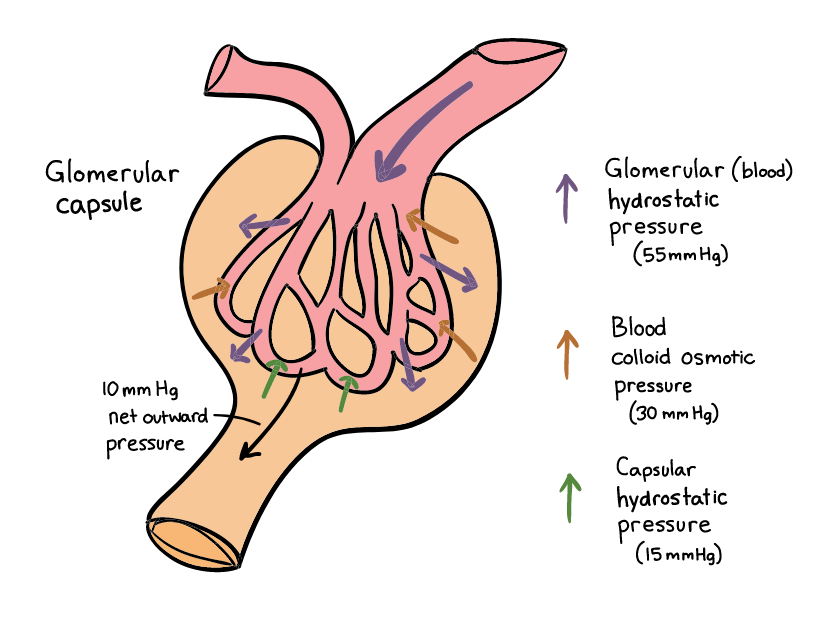
https://www.khanacademy.org/test-prep/mcat/organ-systems/the-renal-system/a/renal-physiology-glomerular-filtration

# Dataset and Goal
The dataset contains images of kidneys 11 fresh frozen and 9 Formalin Fixed Paraffin Embedded (FFPE) PAS kidney images. <br>
There can be over 600,000 glomeruli in each human kidney, each with a range from 100-350μm. <br>
**Goal:** Develop segmentation algorithms that identify glomeruli in the PAS stained microscopy data.

## Map of the training and testing images
*8 train .tiff images* <br>
*5 test .tiff images*

In [ ]:
! cd ../input/hubmap-kidney-segmentation/train && ls

In [ ]:
TRAIN_PATH = "../input/hubmap-kidney-segmentation/train/"
TEST_PATH = "../input/hubmap-kidney-segmentation/test/"
## Extra dataset information about all the training images
dataset_info = pd.read_csv("../input/hubmap-kidney-segmentation/HuBMAP-20-dataset_information.csv")
print(dataset_info.shape)
dataset_info.head(13).T

In [ ]:
## Training dataset information
train_df = pd.read_csv("../input/hubmap-kidney-segmentation/train.csv")
train_df.head().T # Contains the training image id and the RLE

# Looking into one random image from the train dataset

In [ ]:
# Looking into the anatomical_structure json files
with open(TRAIN_PATH + train_df.iloc[4, 0] + "-anatomical-structure.json") as f:
    data = json.load(f)
# print(json.dumps(data[0], indent=4, sort_keys=True))
print(data[0]) # Looking into the first Glomerulus coordinates

In [ ]:
## Looking into a single training image
image1 = tiff.imread(TRAIN_PATH + train_df.iloc[4, 0] + ".tiff")
print(train_df.iloc[1, 0], " training image with a shape of -->", image1.shape)

In [ ]:
## The kidney tissue image
image1 = image1[0][0].transpose(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(image1)
plt.show()

# Decoding and adding the mask

In [ ]:
## We need to decode the mask from encoding column of train.csv
## https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    print(starts, ends)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [ ]:
## Plot all the Glomeruli in this particular kidney
mask1 = rle2mask(train_df.iloc[4, 1], (image1.shape[1], image1.shape[0])) # Call the RLE2Mask function

In [ ]:
## The same kidney image with all the masks
plt.figure(figsize=(10, 10))
plt.imshow(image1)
plt.imshow(mask1, alpha=0.5, cmap='plasma')
plt.show()

# Get bounding boxes for all the Glomeruli

In [ ]:
## Identify all the coordinates of the glomeruli in this image
lbl_0 = label(mask1) 
props = regionprops(lbl_0)
len(props) ## There are 198 glomeruli's identified
bboxes = [] ## Convert all the 198 items into bounding boxes so we can save these images for training
for prop in props:
    bboxes.append([prop.bbox[0] - 30, prop.bbox[1] - 30, 
                   prop.bbox[2] + 30, prop.bbox[3] + 30]) ## Adding a little bit of extra image run

In [ ]:
## From the above algorithm we identify and plot a single glomeruli from the kidney
plt.figure(figsize=(10, 10))
plt.imshow(image1[bboxes[0][0]:bboxes[0][2], bboxes[0][1]:bboxes[0][3], :])
plt.imshow(mask1[bboxes[0][0]:bboxes[0][2], bboxes[0][1]:bboxes[0][3]], alpha=0.5, cmap='plasma')
plt.show()

## There we go, we have identified a Glomeruli, it's mask and it's corresponding BBOX

In [ ]:
## Let's look into some more of these glomeruli
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
val = 10
for i in range(2):
    for j in range(5):
        axes[i, j].imshow(image1[bboxes[val][0]:bboxes[val][2], bboxes[val][1]:bboxes[val][3], :]); val += 1
        axes[i, j].axis('off')
plt.show()

In [ ]:
## Glomeruli with masks
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
val = 10
for i in range(2):
    for j in range(5):
        axes[i, j].imshow(image1[bboxes[val][0]:bboxes[val][2], bboxes[val][1]:bboxes[val][3], :])
        axes[i, j].imshow(mask1[bboxes[val][0]:bboxes[val][2], bboxes[val][1]:bboxes[val][3]], alpha=0.5, cmap='plasma')
        axes[i, j].axis('off'); val += 1
plt.show()

In [ ]:
## Only masks
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
val = 10
for i in range(2):
    for j in range(5): 
        axes[i, j].imshow(mask1[bboxes[val][0]:bboxes[val][2], bboxes[val][1]:bboxes[val][3]], cmap='gray')
        axes[i, j].axis('off'); val += 1
plt.show()

# Generating the dataset

In [ ]:
## I will be only creating dataset for this one image, but you will have to create the data using all the 8 images
## I will also be using the Albumentation package for generating image augmented data
import albumentations as A

augment = A.Compose([
    A.ShiftScaleRotate(),
    A.HorizontalFlip(p=1),
    A.CLAHE(p=1),
    A.RandomRotate90(),
    A.ElasticTransform(),
], p=1)

augmented = augment(image=image1[bboxes[3][0]:bboxes[3][2], bboxes[3][1]:bboxes[3][3], :], \
                    mask=mask1[bboxes[3][0]:bboxes[3][2], bboxes[3][1]:bboxes[3][3]]) ## Apply first transformation
augmented2 = augment(image=image1[bboxes[3][0]:bboxes[3][2], bboxes[3][1]:bboxes[3][3], :], \
                    mask=mask1[bboxes[3][0]:bboxes[3][2], bboxes[3][1]:bboxes[3][3]]) ## Apply second transformation

In [ ]:
## From the above algorithm we identify and plot a single glomeruli from the kidney
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0, 0].imshow(image1[bboxes[3][0]:bboxes[3][2], bboxes[3][1]:bboxes[3][3], :]); axes[0, 0].axis('off')
axes[1, 0].imshow(mask1[bboxes[3][0]:bboxes[3][2], bboxes[3][1]:bboxes[3][3]], cmap='gray'); axes[1, 0].axis('off')

axes[0, 1].imshow(augmented['image']); axes[0, 1].axis('off')
axes[1, 1].imshow(augmented['mask']); axes[1, 1].axis('off')

axes[0, 2].imshow(augmented2['image']); axes[0, 2].axis('off')
axes[1, 2].imshow(augmented2['mask']); axes[1, 2].axis('off')

plt.show()

# Reference 🏛

[1] [Nayu.T.S's Visualization NB](https://www.kaggle.com/nayuts/hubmap-let-s-visualize-and-understand-dataset)